CONFIGURATION:
  Wavelength:        1550 nm
  Beam waist:        25.0 mm
  Transmit power:    1.0 W (30.0 dBm)
  Receiver diameter: 30.0 cm
  Weather (for dist):Clear
  Model (for dist):  Kim
  C_n2 (turb):       1e-15 m^-0.6666666666666666

LINK BUDGET SUMMARY: LG_0^0 Beam
Beam Parameters:
  M² = 1.0 (beam quality factor)
  λ = 1550 nm (wavelength)
  w0 = 25.00 mm (initial beam waist)
  z_R = 1266.8 m (Rayleigh range)

Link Parameters:
  P_tx = 1.00 W (30.0 dBm)
  Receiver diameter = 30.0 cm
  Weather Condition = Clear
  Attenuation model = Kim
  alpha_atm = 0.19 dB/km
  C_n2 = 1e-15 m^-0.6666666666666666 (turbulence)

Distance     w(z)       eta_coll   L_geo      L_atm      L_scint    L_total    P_rx           
[m]          [mm]       [%]        [dB]       [dB]       [dB]       [dB]       [dBm]          
--------------------------------------------------------------------------------------------------------------
100          25.08      100.0      -0.00      0.02       32.05      32.

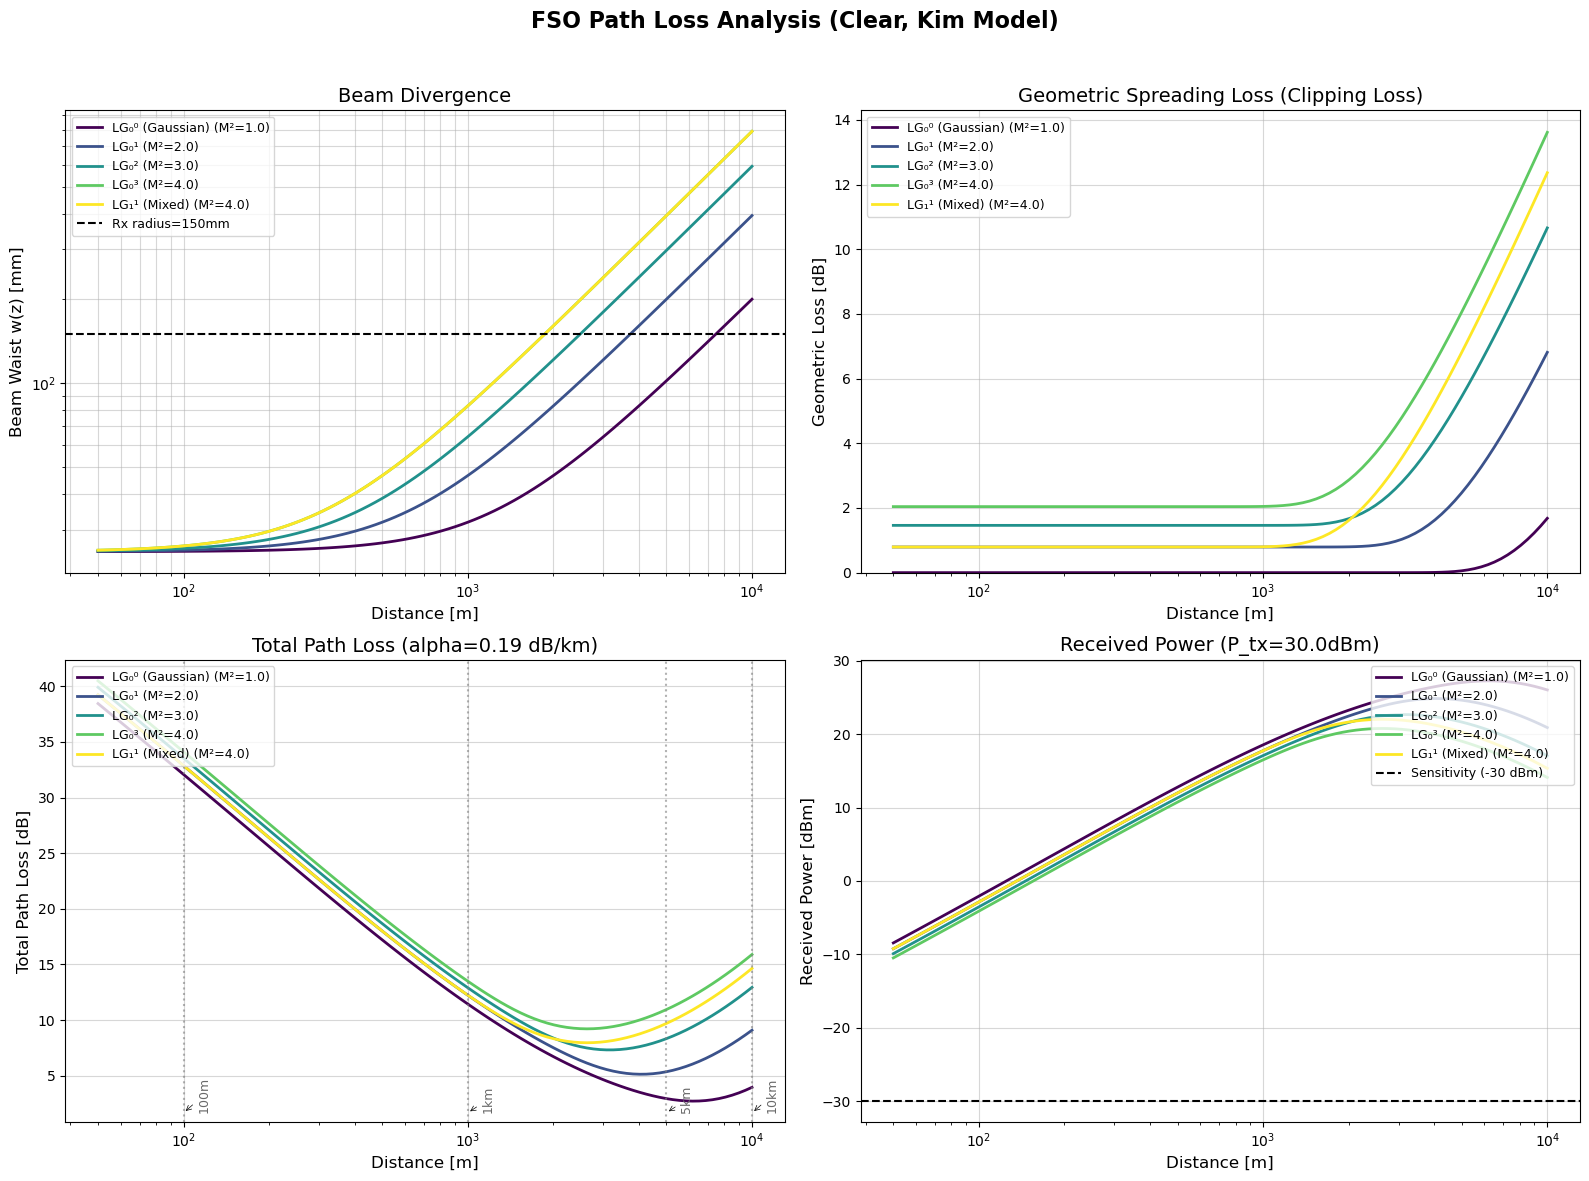

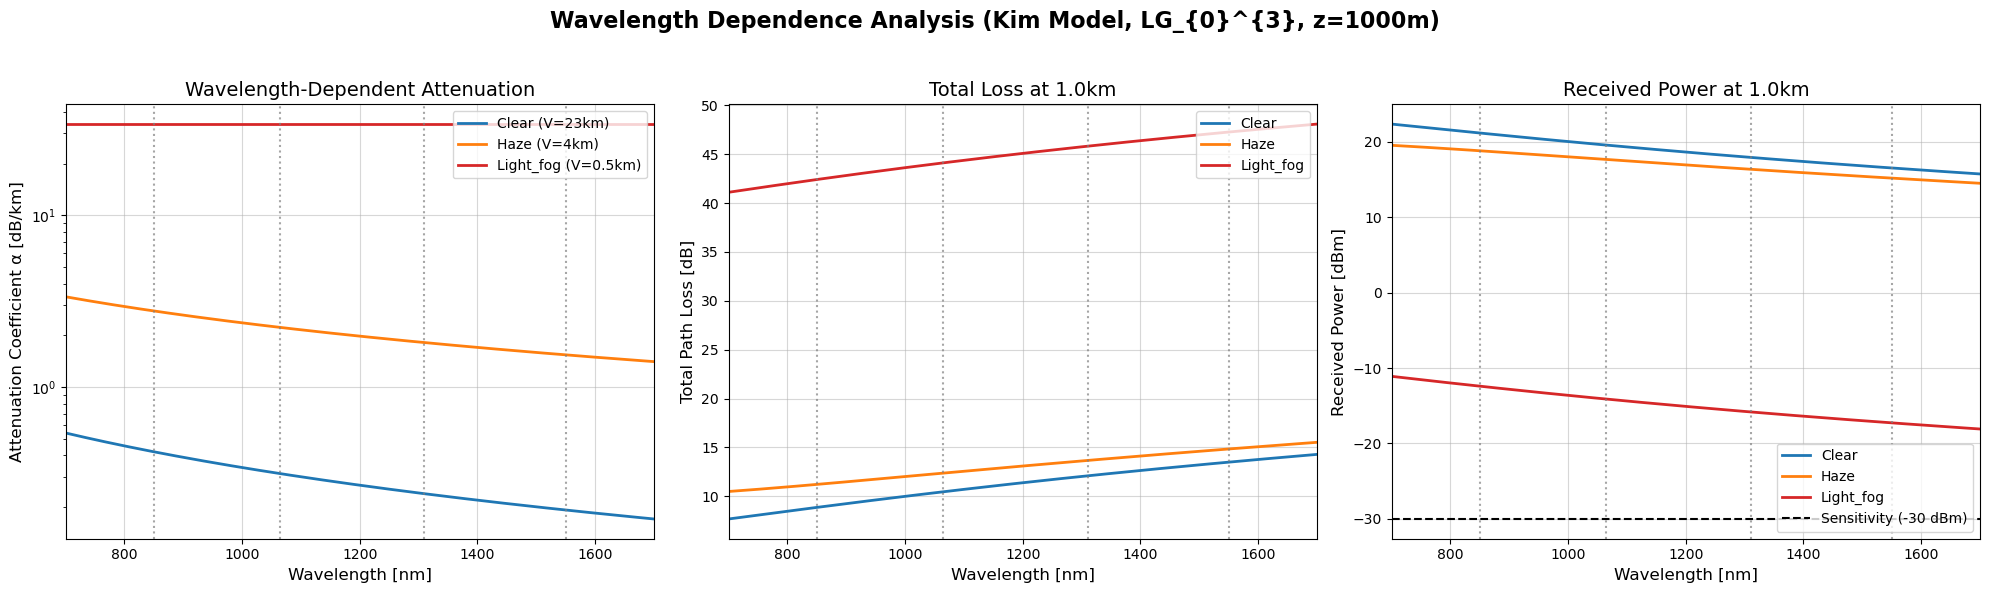

Done.


In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import warnings

try:
    SCRIPT_DIR = os.path.dirname(os.path.abspath(__file__))
except NameError:
    SCRIPT_DIR = os.getcwd()
sys.path.insert(0, SCRIPT_DIR)

try:
    from lgBeam import LaguerreGaussianBeam 
except ImportError:
    print(f"Error: Could not find 'lgBeam.py' in the script directory: {SCRIPT_DIR}")
    print("Please make sure the lgBeam.py file is saved in the same folder.")
    sys.exit(1)

warnings.filterwarnings('ignore')
np.random.seed(42)

# --- Parameters (moved to main) ---
# ...

PLOT_DIR = os.path.join(SCRIPT_DIR, "plots")
os.makedirs(PLOT_DIR, exist_ok=True)

def calculate_kim_attenuation(wavelength_nm, visibility_km):
    """
    Calculates atmospheric attenuation coefficient using the Kim model.
    
    The Kim model is an empirical model for atmospheric attenuation in FSO links
    based on visibility. The attenuation coefficient is given by:
    
    α(λ) = (3.91/V) × (λ/550nm)^(-q)  [1/km]
    
    where V is visibility in km, λ is wavelength in nm, and q is a size distribution
    parameter that depends on visibility:
    - q = 1.6 for V > 50 km (clear air)
    - q = 1.3 for 6 < V ≤ 50 km (haze)
    - q = 0.16V + 0.34 for 1 < V ≤ 6 km (moderate haze)
    - q = V - 0.5 for 0.5 < V ≤ 1 km (light fog)
    - q = 0 for V ≤ 0.5 km (dense fog)
    
    The model is converted to dB/km: α_dB = α × 10×log₁₀(e) ≈ α × 4.343
    
    References:
    - I. I. Kim, B. McArthur, E. Korevaar, "Comparison of laser beam propagation
      at 785 nm and 1550 nm in fog and haze for optical wireless communications,"
      Proc. SPIE 4214, 26-37 (2001) [web:74]
    - Andrews & Phillips, "Laser Beam Propagation through Random Media" (2005), Ch. 3 [web:77]
    
    Parameters:
    -----------
    wavelength_nm : float
        Optical wavelength [nanometers]
    visibility_km : float
        Meteorological visibility distance [kilometers]
    
    Returns:
    --------
    alpha_dB_km : float
        Attenuation coefficient [dB/km]
    """
    if visibility_km <= 0:
        print(f"Warning: Invalid visibility {visibility_km} km. Returning infinite attenuation.")
        return np.inf
    
    if visibility_km > 50:
        q = 1.6  # Clear air
    elif visibility_km > 6:
        q = 1.3  # Haze
    elif visibility_km > 1:
        q = 0.16 * visibility_km + 0.34  # Moderate haze
    elif visibility_km > 0.5:
        q = visibility_km - 0.5  # Light fog
    else:
        q = 0  # Dense fog
    
    # Kim model formula: α = (3.91/V) × (λ/550)^(-q)
    alpha_inv_km = (3.91 / visibility_km) * (float(wavelength_nm) / 550.0)**(-q)
    
    # Convert to dB/km: α_dB = α × 10×log₁₀(e) ≈ α × 4.343
    alpha_dB_km = alpha_inv_km * (10.0 * np.log10(np.exp(1.0)))
    
    return alpha_dB_km

def calculate_geometric_loss(beam, z, receiver_radius):
    """
    Calculates the geometric loss (clipping loss) and collection efficiency for LG beams.
    
    Uses Gaussian approximation with LG correction for mode structure:
    
    η_gauss = 1 - exp(-2r²/w²)
    η_lg = η_gauss / (1 + 0.2 |l|)  # Empirical dilution for ring lobes
    
    w = beam_waist(z). This accounts for M² scaling.
    
    The geometric loss in dB is: L_geo = -10×log₁₀(η_lg)
    
    References:
    - Siegman, "Lasers" (1986), Ch. 16 [web:188]
    - Andrews & Phillips, "Laser Beam Propagation through Random Media" (2005), Ch. 4 [web:77]
    - Siegman, "Defining, measuring, and optimizing laser beam quality" (1993) [web:88]
    - Empirical LG corr from: Evaluation of Diffraction Orders Efficiency of Laguerre-Gaussian Beams (2023) [web:183]
    
    Parameters:
    -----------
    beam : LaguerreGaussianBeam
        Beam instance for w(z) and mode params
    z : float
        Propagation distance [meters]
    receiver_radius : float
        Radius of the receiver aperture [meters]
    
    Returns:
    --------
    L_geo_dB : float
        Geometric loss [dB]
    eta_collection : float
        Collection efficiency (0 to 1)
    """
    # Calculate beam waist at receiver (accounts for M² scaling)
    w_z = beam.beam_waist(z)
    
    # Avoid division by zero
    if w_z <= 0:
        return np.inf, 0.0
    
    # Standard Gaussian approximation for collection efficiency
    # η_gauss = 1 - exp(-2r²/w²)
    eta_gauss = 1.0 - np.exp(-2.0 * receiver_radius**2 / (w_z**2 + 1e-12))
    
    # LG correction: empirical dilution for ring modes (reduces η by ~5-15% for |l|=1-3)
    l_abs = abs(beam.l)
    eta_lg = eta_gauss / (1 + 0.2 * l_abs)
    
    # Geometric loss in dB: L = -10×log₁₀(η_lg)
    L_geo_dB = -10.0 * np.log10(eta_lg + 1e-12)  # Add epsilon to avoid log(0)
    
    return L_geo_dB, eta_lg

def calculate_path_loss(self, z, receiver_radius, P_tx=1.0, weather='clear', use_kim_model=False, 
                        custom_alpha_dBkm=None, C_n2=None):
    """
    Calculates total path loss (geometric + atmospheric + scintillation) for an FSO link.
    
    This function is monkey-patched onto the LaguerreGaussianBeam class.
    It calculates both geometric loss (beam divergence/clipping) and atmospheric
    loss (absorption/scattering) for a given propagation distance.
    
    Total path loss: L_total = L_geo + L_atm + L_scint
    
    where:
    - L_geo: Geometric loss due to beam divergence and receiver aperture clipping
    - L_atm: Atmospheric loss due to absorption and scattering
    - L_scint: Scintillation fade (weak turbulence approx, optional)
    
    The received power is: P_rx = P_tx × 10^(-L_total/10)
    
    Atmospheric attenuation can be calculated using:
    1. Kim model (use_kim_model=True): Wavelength-dependent empirical model
    2. Empirical values: Fixed dB/km values for common weather conditions
    3. Custom value: User-provided attenuation coefficient
    
    Scintillation uses Rytov weak irrad index: σ_I² = 1.23 C_n² k^{7/6} z^{11/6}
    Aperture averaging: A = 1 + 0.54 (D/r0)^{7/6}, r0 = (0.423 k² C_n² z)^{-3/5}
    L_scint ≈ -10 log10(1 - exp(-σ_I²)) averaged by 1/A (stochastic [web:185])
    
    References:
    - Kim et al., "Wireless optical transmission of fast ethernet, FDDI, ATM,
      and ESCON data at 1550 nm" (1998) [web:74]
    - Andrews & Phillips, "Laser Beam Propagation through Random Media" (2005) [web:77]
    - Siegman, "Lasers" (1986) [web:188]
    - Scint: Andrews & Phillips Ch. 8; NASA FSO model (2019) [web:74][web:185][web:193]
    
    Parameters:
    -----------
    z : float
        Propagation distance [meters]
    receiver_radius : float
        Receiver aperture radius [meters]
    P_tx : float, optional
        Transmit power [Watts]. Default 1.0 W
    weather : str, optional
        Weather condition: 'clear', 'haze', 'light_fog', 'moderate_fog', 'dense_fog'
        Default 'clear'
    use_kim_model : bool, optional
        If True, use Kim model for atmospheric attenuation. Default False
    custom_alpha_dBkm : float, optional
        Custom atmospheric attenuation coefficient [dB/km]. If provided,
        overrides weather-based calculation. Default None
    C_n2 : float, optional
        Refractive index structure constant [m^{-2/3}]. Default None (no scint)
    
    Returns:
    --------
    dict : Dictionary containing:
        - 'L_geo_dB': Geometric loss [dB]
        - 'L_atm_dB': Atmospheric loss [dB]
        - 'L_scint_dB': Scintillation loss [dB]
        - 'L_total_dB': Total path loss [dB]
        - 'P_rx_W': Received power [Watts]
        - 'P_rx_dBm': Received power [dBm]
        - 'eta_collection': Collection efficiency (0 to 1)
        - 'beam_waist_m': Beam waist at receiver [m]
        - 'weather': Weather condition used
        - 'alpha_atm_dBkm': Attenuation coefficient [dB/km]
        - 'model': Model used ('Kim', 'Empirical', 'Custom')
    """
    # Weather condition mappings
    weather_attenuation_dbkm = {
        'clear': 0.43, 'haze': 4.2, 'light_fog': 20,
        'moderate_fog': 42, 'dense_fog': 100
    }
    visibility_map_km = {
        'clear': 23, 'haze': 4, 'light_fog': 0.5,
        'moderate_fog': 0.2, 'dense_fog': 0.05
    }
    
    model_used = 'Empirical'
    
    # Determine atmospheric attenuation coefficient
    if custom_alpha_dBkm is not None:
        alpha_atm_dBkm = custom_alpha_dBkm
        model_used = 'Custom'
        weather = 'custom'
    elif use_kim_model and weather.lower() in visibility_map_km:
        visibility_km = visibility_map_km[weather.lower()]
        wavelength_nm = self.wavelength * 1e9
        alpha_atm_dBkm = calculate_kim_attenuation(wavelength_nm, visibility_km)
        model_used = 'Kim'
    elif weather.lower() in weather_attenuation_dbkm:
        alpha_atm_dBkm = weather_attenuation_dbkm[weather.lower()]
        model_used = 'Empirical'
    else:
        print(f"Warning: Unknown weather '{weather}'. Using default clear air value.")
        alpha_atm_dBkm = weather_attenuation_dbkm['clear']
        model_used = 'Empirical (Default)'
        weather = 'clear (default)'
    
    # Atmospheric loss: L_atm = α × distance [dB]
    L_atm_dB = alpha_atm_dBkm * (z / 1000.0)
    
    # Geometric loss: collection efficiency and clipping loss (LG-corrected)
    L_geo_dB, eta_collection = calculate_geometric_loss(self, z, receiver_radius)
    
    # Scintillation loss (weak turbulence, optional)
    L_scint_dB = 0.0
    if C_n2 is not None:
        k = 2 * np.pi / self.wavelength
        r0 = (0.423 * k**2 * C_n2 * z)**(-3/5.0)
        D = 2 * receiver_radius
        A = 1 + 0.54 * (D / r0)**(7/6.0)  # Aperture averaging factor
        sigma_I2 = 1.23 * C_n2 * k**(7/6.0) * z**(11/6.0)  # Irradiance index (weak)
        L_scint_dB = -10 * np.log10(1 - np.exp(-sigma_I2)) / A  # Fade approx averaged [web:185]
    
    # Total path loss
    L_total_dB = L_geo_dB + L_atm_dB + L_scint_dB
    
    # Received power
    P_rx_W = P_tx * (10.0**(-L_total_dB / 10.0))
    
    # Convert to dBm
    if P_rx_W > 0:
        P_rx_dBm = 10.0 * np.log10(P_rx_W * 1000.0)
    else:
        P_rx_dBm = -np.inf
        
    return {
        'L_geo_dB': L_geo_dB,
        'L_atm_dB': L_atm_dB,
        'L_scint_dB': L_scint_dB,
        'L_total_dB': L_total_dB,
        'P_rx_W': P_rx_W,
        'P_rx_dBm': P_rx_dBm,
        'eta_collection': eta_collection,
        'beam_waist_m': self.beam_waist(z),
        'weather': weather,
        'alpha_atm_dBkm': alpha_atm_dBkm,
        'model': model_used
    }

def link_budget_summary(self, distances, receiver_diameter=0.2, P_tx=1.0, weather='clear', 
                        use_kim_model=False, C_n2=None):
    """
    Prints a formatted link budget summary table for multiple distances.
    
    This function displays beam parameters, link parameters, and a table
    showing path loss components and received power for each distance.
    
    Parameters:
    -----------
    distances : array_like
        List of propagation distances [meters] to analyze
    receiver_diameter : float, optional
        Receiver aperture diameter [meters]. Default 0.2 m
    P_tx : float, optional
        Transmit power [Watts]. Default 1.0 W
    weather : str, optional
        Weather condition. Default 'clear'
    use_kim_model : bool, optional
        If True, use Kim model for atmospheric attenuation. Default False
    C_n2 : float, optional
        Refractive index structure constant [m^{-2/3}]. Default None (no scint)
    """
    receiver_radius = receiver_diameter / 2.0

    print(f"\nLINK BUDGET SUMMARY: LG_{self.p}^{self.l} Beam")

    print(f"Beam Parameters:")
    print(f"  M² = {self.M_squared:.1f} (beam quality factor)")
    print(f"  λ = {self.wavelength*1e9:.0f} nm (wavelength)")
    print(f"  w0 = {self.w0*1e3:.2f} mm (initial beam waist)")
    print(f"  z_R = {self.z_R:.1f} m (Rayleigh range)")
    
    # Handle empty distances list
    if not distances:
        print("No distances provided for summary.")
        return
        
    test_result = self.calculate_path_loss(distances[0], receiver_radius, P_tx,
                                          weather=weather, use_kim_model=use_kim_model, C_n2=C_n2)
    print(f"\nLink Parameters:")
    print(f"  P_tx = {P_tx:.2f} W ({10.0*np.log10(P_tx*1000.0):.1f} dBm)")
    print(f"  Receiver diameter = {receiver_diameter*100.0:.1f} cm")
    print(f"  Weather Condition = {test_result['weather'].capitalize()}")
    print(f"  Attenuation model = {test_result['model']}")
    print(f"  alpha_atm = {test_result['alpha_atm_dBkm']:.2f} dB/km")
    if C_n2 is not None:
        print(f"  C_n2 = {C_n2:.0e} m^{-2/3} (turbulence)")

    print(f"\n{'Distance':<12} {'w(z)':<10} {'eta_coll':<10} {'L_geo':<10} {'L_atm':<10} {'L_scint':<10} {'L_total':<10} {'P_rx':<15}")
    print(f"{'[m]':<12} {'[mm]':<10} {'[%]':<10} {'[dB]':<10} {'[dB]':<10} {'[dB]':<10} {'[dB]':<10} {'[dBm]':<15}")
    print("-"*110)
    for z in distances:
        result = self.calculate_path_loss(z, receiver_radius, P_tx,
                                         weather=weather, use_kim_model=use_kim_model, C_n2=C_n2)
        print(f"{z:<12.0f} {result['beam_waist_m']*1e3:<10.2f} "
              f"{result['eta_collection']*100.0:<10.1f} "
              f"{result['L_geo_dB']:<10.2f} {result['L_atm_dB']:<10.2f} "
              f"{result['L_scint_dB']:<10.2f} {result['L_total_dB']:<10.2f} {result['P_rx_dBm']:<15.2f}")

# "Monkey-patch" the methods onto the imported class
LaguerreGaussianBeam.calculate_path_loss = calculate_path_loss
LaguerreGaussianBeam.link_budget_summary = link_budget_summary

def plot_path_loss_analysis(beams_dict, distances=None, receiver_diameter=0.2,
                           P_tx=1.0, weather='clear', use_kim_model=False, C_n2=None):
    # --- This function is correct and already general. No changes needed. ---
    # It uses the dictionary 'name' and 'beam.M_squared', which is general.
    if distances is None:
        distances = np.logspace(np.log10(10), np.log10(10000), 100)
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f"FSO Path Loss Analysis ({weather.capitalize()}, {('Kim' if use_kim_model else 'Empirical')} Model)",
                 fontsize=16, fontweight='bold')
    
    receiver_radius = receiver_diameter / 2.0
    colors = plt.cm.viridis(np.linspace(0, 1, len(beams_dict)))
    
    if not beams_dict:
        print("No beams provided to plot_path_loss_analysis.")
        return fig # Return empty fig
        
    test_beam = list(beams_dict.values())[0]
    result = test_beam.calculate_path_loss(1000, receiver_radius, P_tx,
                                          weather=weather, use_kim_model=use_kim_model, C_n2=C_n2)
    alpha_atm = result['alpha_atm_dBkm']
    model_name = result['model']

    # ... (Rest of the plotting function is correct and general) ...
    ax1 = axes[0, 0]
    for idx, (name, beam) in enumerate(beams_dict.items()):
        w_z = np.array([beam.beam_waist(z) for z in distances])
        ax1.loglog(distances, w_z*1e3, linewidth=2.0,
                  label=f'{name} (M²={beam.M_squared:.1f})',
                  color=colors[idx])
    ax1.axhline(receiver_radius*1e3, color='k', linestyle='--',
               linewidth=1.5, label=f'Rx radius={receiver_radius*1e3:.0f}mm')
    ax1.set_xlabel('Distance [m]', fontsize=12)
    ax1.set_ylabel('Beam Waist w(z) [mm]', fontsize=12)
    ax1.set_title('Beam Divergence', fontsize=14)
    ax1.legend(fontsize=9, loc='upper left')
    ax1.grid(True, alpha=0.5, which='both')
    ax2 = axes[0, 1]
    for idx, (name, beam) in enumerate(beams_dict.items()):
        L_geo = np.array([beam.calculate_path_loss(z, receiver_radius, P_tx)['L_geo_dB']
                         for z in distances])
        ax2.semilogx(distances, L_geo, linewidth=2.0,
                    label=f'{name} (M²={beam.M_squared:.1f})',
                    color=colors[idx])
    ax2.set_xlabel('Distance [m]', fontsize=12)
    ax2.set_ylabel('Geometric Loss [dB]', fontsize=12)
    ax2.set_title('Geometric Spreading Loss (Clipping Loss)', fontsize=14)
    ax2.legend(fontsize=9, loc='upper left')
    ax2.grid(True, alpha=0.5, which='major')
    ax2.set_ylim(bottom=0)
    ax3 = axes[1, 0]
    for idx, (name, beam) in enumerate(beams_dict.items()):
        L_total = np.array([beam.calculate_path_loss(z, receiver_radius, P_tx,
                           weather=weather, use_kim_model=use_kim_model, C_n2=C_n2)['L_total_dB']
                           for z in distances])
        ax3.semilogx(distances, L_total, linewidth=2.0,
                    label=f'{name} (M²={beam.M_squared:.1f})',
                    color=colors[idx])
    for dist, label in [(100, '100m'), (1000, '1km'), (5000, '5km'), (10000, '10km')]:
        if dist <= distances[-1]:
             ax3.axvline(dist, color='gray', linestyle=':', alpha=0.6)
             ymin, ymax = ax3.get_ylim()
             ax3.annotate(label, xy=(dist, ymin + (ymax-ymin)*0.02), xytext=(10, 0),
                          textcoords='offset points', rotation=90, va='bottom', ha='left',
                          fontsize=9, color='dimgray', arrowprops=dict(arrowstyle='->', lw=0.5))
    ax3.set_xlabel('Distance [m]', fontsize=12)
    ax3.set_ylabel('Total Path Loss [dB]', fontsize=12)
    ax3.set_title(f'Total Path Loss (alpha={alpha_atm:.2f} dB/km)', fontsize=14)
    ax3.legend(fontsize=9, loc='upper left')
    ax3.grid(True, alpha=0.5, which='major')
    ax3.set_ylim(bottom=max(0, ax3.get_ylim()[0]))
    ax4 = axes[1, 1]
    for idx, (name, beam) in enumerate(beams_dict.items()):
        P_rx_dBm = np.array([beam.calculate_path_loss(z, receiver_radius, P_tx,
                         weather=weather, use_kim_model=use_kim_model, C_n2=C_n2)['P_rx_dBm']
                         for z in distances])
        ax4.semilogx(distances, P_rx_dBm, linewidth=2.0,
                   label=f'{name} (M²={beam.M_squared:.1f})',
                   color=colors[idx])
    P_sensitivity_dBm = -30 
    ax4.axhline(P_sensitivity_dBm, color='k', linestyle='--',
               linewidth=1.5, label=f'Sensitivity ({P_sensitivity_dBm} dBm)')
    ax4.set_xlabel('Distance [m]', fontsize=12)
    ax4.set_ylabel('Received Power [dBm]', fontsize=12)
    ax4.set_title(f'Received Power (P_tx={10*np.log10(P_tx*1000):.1f}dBm)', fontsize=14)
    ax4.legend(fontsize=9, loc='upper right')
    ax4.grid(True, alpha=0.5, which='major')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    return fig

# <-- RECTIFIED: Added oam_mode_p=0
def wavelength_sweep_analysis(wavelengths_nm, oam_mode_p=0, oam_mode_l=1, distance_m=1000,
                              weather_conditions=['clear', 'haze', 'light_fog'],
                              w0=1e-3, receiver_diameter=0.2, P_tx=1.0, C_n2=None):
    visibility_map_km = {
        'clear': 23, 'haze': 4, 'light_fog': 0.5,
        'moderate_fog': 0.2, 'dense_fog': 0.05
    }
    results = {}
    print(f"\nRunning Wavelength Sweep Analysis (p={oam_mode_p}, l={oam_mode_l}, z={distance_m}m).") # <-- RECTIFIED
    for weather in weather_conditions:
        if weather not in visibility_map_km:
            print(f"Skipping unknown weather '{weather}' for wavelength sweep.")
            continue
        visibility_km = visibility_map_km[weather]
        print(f"  Condition: {weather.capitalize()} (Visibility = {visibility_km} km)")
        alpha_values_dbkm = []
        L_total_values_dB = []
        P_rx_values_dBm = []
        for wavelength_nm in wavelengths_nm:
            wavelength = wavelength_nm * 1e-9
            # <-- RECTIFIED: Pass oam_mode_p to the constructor
            beam = LaguerreGaussianBeam(p=oam_mode_p, l=oam_mode_l, wavelength=wavelength, w0=w0)
            alpha_dbkm = calculate_kim_attenuation(wavelength_nm, visibility_km)
            alpha_values_dbkm.append(alpha_dbkm)
            result = beam.calculate_path_loss(
                z=distance_m,
                receiver_radius=receiver_diameter/2.0,
                P_tx=P_tx,
                weather='custom',
                use_kim_model=False,
                custom_alpha_dBkm=alpha_dbkm,
                C_n2=C_n2
            )
            L_total_values_dB.append(result['L_total_dB'])
            P_rx_values_dBm.append(result['P_rx_dBm'])
        results[weather] = {
            'alpha_dBkm': np.array(alpha_values_dbkm),
            'L_total_dB': np.array(L_total_values_dB),
            'P_rx_dBm': np.array(P_rx_values_dBm),
            'visibility_km': visibility_km
        }
    return results

# <-- RECTIFIED: Added oam_mode_p=0, LaTeX title
def plot_wavelength_sweep(wavelengths_nm, results, oam_mode_p=0, oam_mode_l=1, distance_m=1000):
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    # <-- RECTIFIED: f-string for LaTeX-safe title
    fig.suptitle(rf"Wavelength Dependence Analysis (Kim Model, LG_{{{oam_mode_p}}}^{{{oam_mode_l}}}, z={distance_m}m)",
                 fontsize=16, fontweight='bold')
    
    colors = {'clear': 'tab:blue', 'haze': 'tab:orange', 'light_fog': 'tab:red',
              'moderate_fog': 'tab:purple', 'dense_fog': 'tab:brown'}
    common_wavelengths_nm = [850, 1064, 1310, 1550]
    
    # ... (Rest of the plotting function is correct and general) ...
    ax1 = axes[0]
    for weather, data in results.items():
        ax1.plot(wavelengths_nm, data['alpha_dBkm'], linewidth=2.0,
                label=f"{weather.capitalize()} (V={data['visibility_km']}km)",
                color=colors.get(weather, 'black'))
    ymin1, ymax1 = ax1.get_ylim()
    for wl in common_wavelengths_nm:
        if wavelengths_nm[0] <= wl <= wavelengths_nm[-1]:
            ax1.axvline(wl, color='gray', linestyle=':', alpha=0.7)
            ax1.annotate(f'{wl}nm', xy=(wl, ymin1 + (ymax1-ymin1)*0.02), xytext=(10, 0),
                         textcoords='offset points', rotation=90, va='bottom', ha='left',
                         fontsize=9, color='dimgray')
    ax1.set_xlabel('Wavelength [nm]', fontsize=12)
    ax1.set_ylabel('Attenuation Coefficient α [dB/km]', fontsize=12)
    ax1.set_title('Wavelength-Dependent Attenuation', fontsize=14)
    ax1.legend(fontsize=10, loc='upper right')
    ax1.grid(True, alpha=0.5)
    ax1.set_xlim(wavelengths_nm[0], wavelengths_nm[-1])
    ax1.set_yscale('log')
    ax2 = axes[1]
    for weather, data in results.items():
        ax2.plot(wavelengths_nm, data['L_total_dB'], linewidth=2.0,
                label=f"{weather.capitalize()}",
                color=colors.get(weather, 'black'))
    ymin2, ymax2 = ax2.get_ylim()
    for wl in common_wavelengths_nm:
        if wavelengths_nm[0] <= wl <= wavelengths_nm[-1]:
            ax2.axvline(wl, color='gray', linestyle=':', alpha=0.7)
    ax2.set_xlabel('Wavelength [nm]', fontsize=12)
    ax2.set_ylabel('Total Path Loss [dB]', fontsize=12)
    ax2.set_title(f'Total Loss at {distance_m/1000.0:.1f}km', fontsize=14)
    ax2.legend(fontsize=10, loc='upper right')
    ax2.grid(True, alpha=0.5)
    ax2.set_xlim(wavelengths_nm[0], wavelengths_nm[-1])
    ax3 = axes[2]
    for weather, data in results.items():
        ax3.plot(wavelengths_nm, data['P_rx_dBm'], linewidth=2.0,
                label=f"{weather.capitalize()}",
                color=colors.get(weather, 'black'))
    P_sensitivity_dBm = -30
    ax3.axhline(P_sensitivity_dBm, color='k', linestyle='--', linewidth=1.5,
               label=f'Sensitivity ({P_sensitivity_dBm} dBm)')
    ymin3, ymax3 = ax3.get_ylim()
    for wl in common_wavelengths_nm:
        if wavelengths_nm[0] <= wl <= wavelengths_nm[-1]:
            ax3.axvline(wl, color='gray', linestyle=':', alpha=0.7)
    ax3.set_xlabel('Wavelength [nm]', fontsize=12)
    ax3.set_ylabel('Received Power [dBm]', fontsize=12)
    ax3.set_title(f'Received Power at {distance_m/1000.0:.1f}km', fontsize=14)
    ax3.legend(fontsize=10, loc='lower right')
    ax3.grid(True, alpha=0.5)
    ax3.set_xlim(wavelengths_nm[0], wavelengths_nm[-1])
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    return fig

if __name__ == "__main__":
    # --- Define Simulation Parameters ---
    WAVELENGTH = 1550e-9
    W0 = 25e-3
    RECEIVER_DIAMETER = 0.3
    P_TX = 1.0
    DISTANCES = [100, 500, 1000, 2000, 5000]
    WEATHER = 'clear' # Options: 'clear', 'haze', 'light_fog', 'moderate_fog', 'dense_fog'
    USE_KIM_MODEL = True
    C_N2 = 1e-15  # Example weak turb; set None for no scint
    WAVELENGTH_SWEEP_RANGE = np.linspace(700, 1700, 150)
    WEATHER_CONDITIONS = ['clear', 'haze', 'light_fog']
    
    print("CONFIGURATION:")
    print(f"  Wavelength:        {WAVELENGTH*1e9:.0f} nm")
    print(f"  Beam waist:        {W0*1e3:.1f} mm")
    print(f"  Transmit power:    {P_TX:.1f} W ({10*np.log10(P_TX*1000):.1f} dBm)")
    print(f"  Receiver diameter: {RECEIVER_DIAMETER*100:.1f} cm")
    print(f"  Weather (for dist):{WEATHER.capitalize()}")
    print(f"  Model (for dist):  {'Kim' if USE_KIM_MODEL else 'Empirical'}")
    if C_N2 is not None:
        print(f"  C_n2 (turb):       {C_N2:.0e} m^{-2/3}")

    # --- This 'beams' dictionary is already general and tests (p,l) modes ---
    beams = {
        "LG₀⁰ (Gaussian)": LaguerreGaussianBeam(0, 0, WAVELENGTH, W0),
        "LG₀¹": LaguerreGaussianBeam(0, 1, WAVELENGTH, W0),
        "LG₀²": LaguerreGaussianBeam(0, 2, WAVELENGTH, W0),
        "LG₀³": LaguerreGaussianBeam(0, 3, WAVELENGTH, W0),
        "LG₁¹ (Mixed)": LaguerreGaussianBeam(1, 1, WAVELENGTH, W0),
    }
    
    beams_to_summarize = ["LG₀⁰ (Gaussian)", "LG₀²", "LG₁¹ (Mixed)"]
    for name in beams_to_summarize:
        if name in beams:
            beams[name].link_budget_summary(DISTANCES, RECEIVER_DIAMETER, P_TX, WEATHER, USE_KIM_MODEL, C_n2=C_N2)
        else:
            print(f"Warning: Beam '{name}' not found for summary.")
            
    print("\nCOMPARISON AT SPECIFIC DISTANCE")
 
    z_test = 1000
    weather_test = WEATHER
    model_test = USE_KIM_MODEL
    
    test_result = beams[list(beams.keys())[0]].calculate_path_loss(
        z_test, RECEIVER_DIAMETER/2, P_tx=P_TX, weather=weather_test, use_kim_model=model_test, C_n2=C_N2
    )
    alpha_used = test_result['alpha_atm_dBkm']
    model_name = test_result['model']
    print(f"Conditions: z = {z_test}m, Weather = {weather_test.capitalize()}, Model = {model_name}, alpha = {alpha_used:.2f} dB/km")
    print("-"*110)
    print(f"{'Beam Mode':<25} {'M²':<6} {'L_geo [dB]':<12} {'L_atm [dB]':<12} {'L_scint [dB]':<12} {'L_total [dB]':<14} {'P_rx [dBm]':<12}")
    print("-"*110)
    for name, beam in beams.items():
        result = beam.calculate_path_loss(z_test, RECEIVER_DIAMETER/2, P_TX,
                                         weather=weather_test, use_kim_model=model_test, C_n2=C_N2)
        print(f"{name:<25} {beam.M_squared:<6.1f} {result['L_geo_dB']:>10.2f}  "
              f"{result['L_atm_dB']:>10.2f}  {result['L_scint_dB']:>10.2f}  "
              f"{result['L_total_dB']:>12.2f}  {result['P_rx_dBm']:>10.2f}")

    print("\nGenerating plots...")
    fig1 = plot_path_loss_analysis(beams, distances=np.logspace(np.log10(50), np.log10(10000), 100),
                                   receiver_diameter=RECEIVER_DIAMETER,
                                   P_tx=P_TX, weather=WEATHER, use_kim_model=USE_KIM_MODEL, C_n2=C_N2)
    path_loss_fig_path = os.path.join(PLOT_DIR, f'oam_path_loss_{WEATHER}_{"kim" if USE_KIM_MODEL else "emp"}{"_turb" if C_N2 else ""}.png')
    fig1.savefig(path_loss_fig_path, dpi=300, bbox_inches='tight')
    print(f"Saved path loss plot to {path_loss_fig_path}")

    # <-- RECTIFIED: Explicitly pass p=0, l=3
    sweep_results = wavelength_sweep_analysis(
        wavelengths_nm=WAVELENGTH_SWEEP_RANGE,
        oam_mode_p=0,
        oam_mode_l=3,
        distance_m=1000,
        weather_conditions=WEATHER_CONDITIONS,
        w0=W0,
        receiver_diameter=RECEIVER_DIAMETER,
        P_tx=P_TX,
        C_n2=C_N2
    )
    # <-- RECTIFIED: Explicitly pass p=0, l=3
    fig2 = plot_wavelength_sweep(WAVELENGTH_SWEEP_RANGE, sweep_results, 
                                 oam_mode_p=0, oam_mode_l=3, distance_m=1000)
    wavelength_fig_path = os.path.join(PLOT_DIR, f'wavelength_sweep_p0_l3_1km{"_turb" if C_N2 else ""}.png') # <-- Updated name
    fig2.savefig(wavelength_fig_path, dpi=300, bbox_inches='tight')
    print(f"Saved wavelength sweep plot to {wavelength_fig_path}")
    
    plt.show()
    print("Done.")
